# **Patient Readmission Risk Prediction**

In [1]:
# Step 1: Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

In [2]:
# Step 2: Load Dataset
df = pd.read_csv("/content/diabetic_data.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (101766, 50)
   encounter_id  patient_nbr             race  ... change diabetesMed readmitted
0       2278392      8222157        Caucasian  ...     No          No         NO
1        149190     55629189        Caucasian  ...     Ch         Yes        >30
2         64410     86047875  AfricanAmerican  ...     No         Yes         NO
3        500364     82442376        Caucasian  ...     Ch         Yes         NO
4         16680     42519267        Caucasian  ...     Ch         Yes         NO

[5 rows x 50 columns]


In [3]:
# Step 3: Data Cleaning

# Replace '?' with NaN
df = df.replace('?', np.nan)

In [4]:
# Check missing values
print("\nMissing values count:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Missing values count:
weight                      98569
max_glu_serum               96420
A1Cresult                   84748
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
patient_nbr                     0
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
encounter_id                    0
admission_type_id               0
discharge_disposition_id        0
gender                          0
age                             0
number_inpatient                0
number_emergency                0
dtype: int64


In [5]:
# Drop high-missing columns
df = df.drop(['weight', 'max_glu_serum', 'A1Cresult', 'payer_code'], axis=1)

In [6]:
# Handle medical_specialty (replace NaN with "Unknown")
df['medical_specialty'] = df['medical_specialty'].fillna("Unknown")

In [7]:
# Impute race and diag columns with mode
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
# Drop irrelevant ID columns
df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

In [9]:
# Replace '?' if still present
df = df.replace('?', np.nan)

In [10]:
print("Remaining Missing Values:\n", df.isnull().sum().sum())

Remaining Missing Values:
 0


**Exploratory Data Analysis (EDA)**

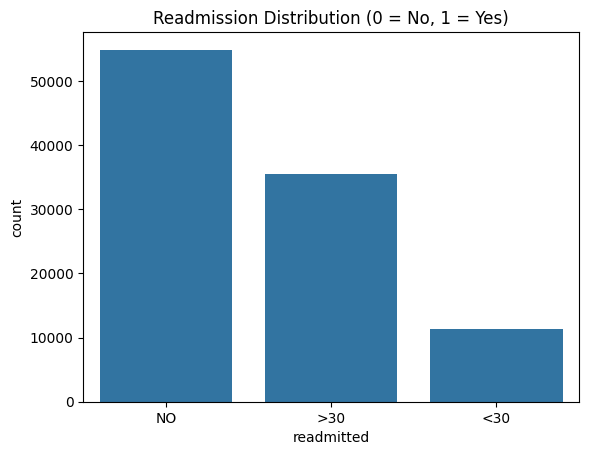

In [11]:
# Step 1. Target variable distribution
sns.countplot(x='readmitted', data=df)
plt.title("Readmission Distribution (0 = No, 1 = Yes)")
plt.show()

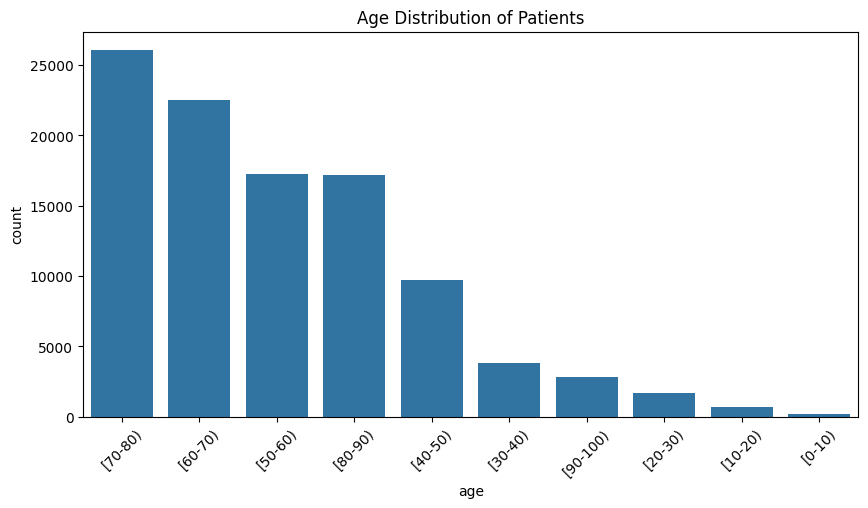

In [12]:
#Step 2. Age distribution
plt.figure(figsize=(10,5))
sns.countplot(x='age', data=df, order=df['age'].value_counts().index)
plt.title("Age Distribution of Patients")
plt.xticks(rotation=45)
plt.show()

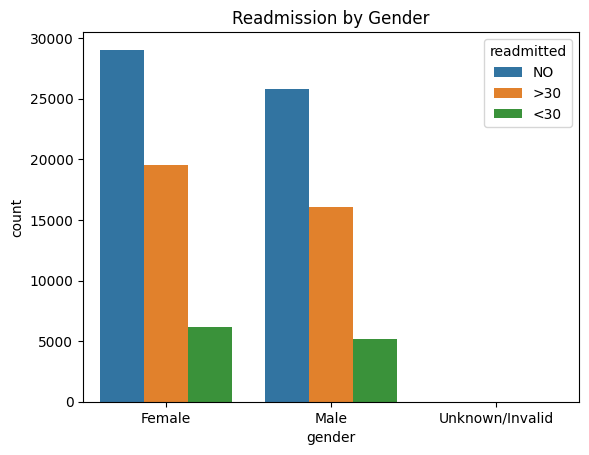

In [13]:
#Step 3. Gender vs Readmission
sns.countplot(x='gender', hue='readmitted', data=df)
plt.title("Readmission by Gender")
plt.show()

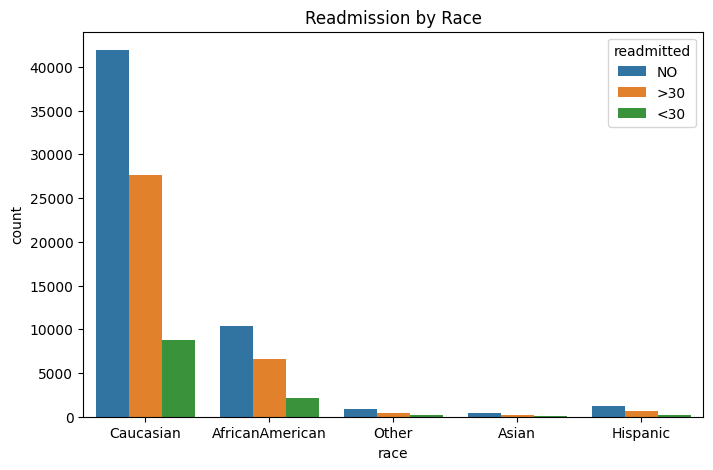

In [14]:
#Step 4. Race vs Readmission
plt.figure(figsize=(8,5))
sns.countplot(x='race', hue='readmitted', data=df)
plt.title("Readmission by Race")
plt.show()

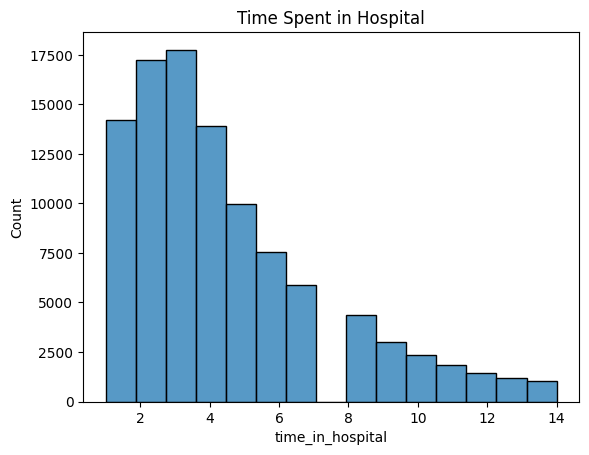

In [15]:
#Step 5. Time in Hospital distribution
sns.histplot(df['time_in_hospital'], bins=15, kde=False)
plt.title("Time Spent in Hospital")
plt.show()

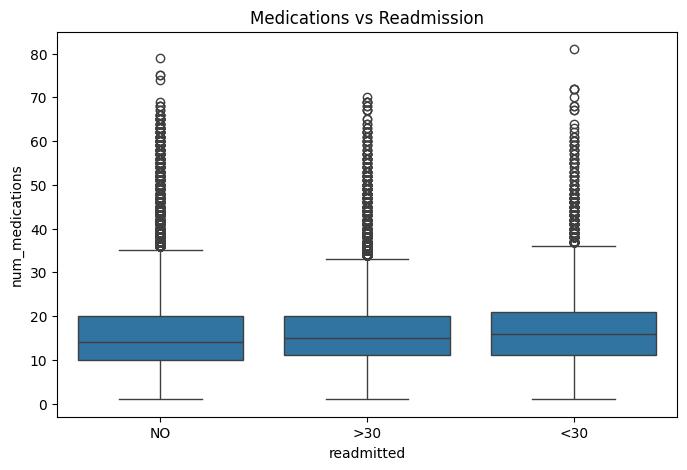

In [16]:
#Step 6. Number of medications vs Readmission
plt.figure(figsize=(8,5))
sns.boxplot(x='readmitted', y='num_medications', data=df)
plt.title("Medications vs Readmission")
plt.show()

**Modeling & Evaluation**

In [17]:
#Step 1: Define Features & Target
# Convert target column: <30 = 1, others = 0
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

X = df.drop(['readmitted', 'readmitted_binary'], axis=1)
y = df['readmitted_binary']

In [18]:
# Step 2: Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))

In [19]:
# Step 3: Balance Dataset with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Original class distribution:\n", y.value_counts())
print("\nAfter SMOTE:\n", y_res.value_counts())

Original class distribution:
 readmitted_binary
0    90409
1    11357
Name: count, dtype: int64

After SMOTE:
 readmitted_binary
0    90409
1    90409
Name: count, dtype: int64


In [20]:
# Step 4: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [21]:
# Step 5: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Step 6: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [23]:
print("\n Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score (Random Forest):", roc_auc_score(y_test, y_pred_rf))


 Random Forest Results:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18082
           1       0.95      0.86      0.90     18082

    accuracy                           0.91     36164
   macro avg       0.91      0.91      0.91     36164
weighted avg       0.91      0.91      0.91     36164

ROC-AUC Score (Random Forest): 0.9075323526158611


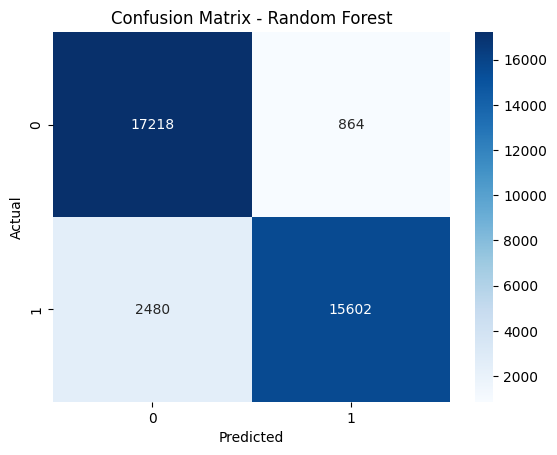

In [24]:
# Step 7: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

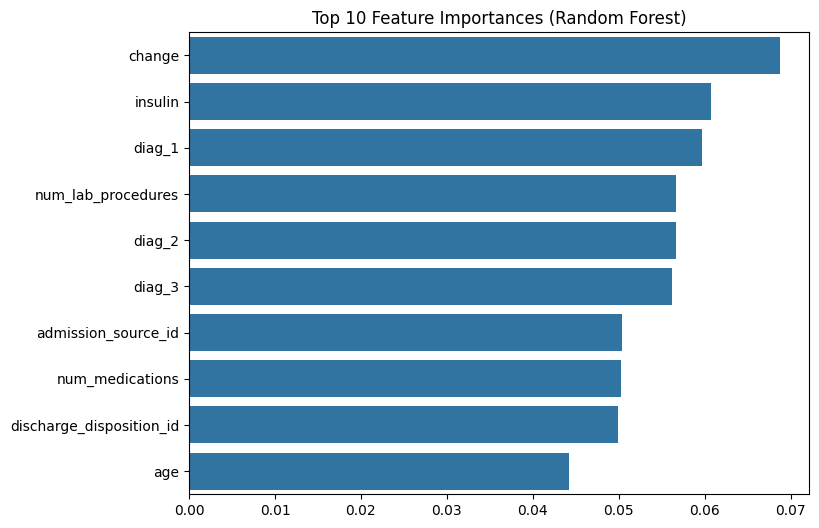

In [25]:
# Step 8: Feature Importance

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [X.columns[i] for i in indices[:10]]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices[:10]], y=top_features)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()